# Proyecto Inteligencia Computacional 

In [1]:
import pandas as pd 
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

feats = pd.read_parquet('./data/features.parquet') 
lcs = pd.read_parquet('./data/lcs.parquet') 
oids = pd.read_parquet('./data/oids.parquet')

## Versión 2 (Autoencoder)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Random Forest

In [3]:
# DataFrame con todas las features de cada objeto + la clase a la que pertenecen
df_feats_class = pd.merge(oids, feats, how="inner", on="oid", sort=True)
df_feats_for_forest = df_feats_class[df_feats_class.columns[1:]]
arr_class = df_feats_for_forest[df_feats_for_forest.columns[0]].values
df_feats_for_forest

,alerceclass,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
0,LPV,1.464396,0.215017,-0.173195,-0.741959,0.976239,0.900859,1.0,0.002542,0.033333,...,20.823200,19.508801,4.200617,1339.718634,17.564814,18.677803,16.661703,628.0,0.112910,0.270302
1,RRL,0.366083,0.104706,0.405444,-1.552645,0.192603,0.883649,1.0,0.000132,-0.100000,...,21.066299,20.175400,0.580561,1251.693287,16.485819,16.641393,16.403305,320.0,0.027691,0.009083
2,LPV,2.839326,0.314243,0.001261,-1.538020,1.494441,0.800329,1.0,0.009013,0.300000,...,21.126600,20.008301,5.057098,1434.977350,16.880259,15.694755,13.155277,656.0,0.180732,0.105483
3,EB,0.029942,0.087856,2.875995,8.698949,0.476514,0.543303,1.0,0.000773,0.033333,...,20.865801,19.922400,2.519390,1189.854849,16.813747,17.039993,16.799618,93.0,0.145533,0.028314
4,LPV,1.512813,0.298351,-0.484697,-0.732266,1.037921,0.791008,1.0,0.004826,-0.233333,...,20.916500,19.762699,5.000990,1338.672627,13.901798,14.856612,12.674696,479.0,0.172507,0.097117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8414,CEP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.019199,19.309700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8415,RRL,0.389800,0.259549,0.506888,-1.274300,0.202627,0.925235,1.0,0.000000,0.033333,...,20.693900,20.560050,0.483679,28.936458,16.840920,17.002280,16.805649,8.0,0.024969,3.964182
8416,DSCT,0.457832,0.359654,0.324823,-1.448713,0.219106,0.893713,1.0,0.000203,-0.100000,...,20.815800,20.049101,0.595043,353.070185,15.650616,15.353477,15.068784,24.0,0.024223,2.072808
8417,RRL,0.347692,0.136953,0.130523,-0.614194,0.192589,0.830999,1.0,0.000217,0.100000,...,20.883900,20.081400,0.794328,375.932407,13.234352,13.045922,12.675948,24.0,0.034678,0.022427


#### Entrenamiento y resultados de Random Forest

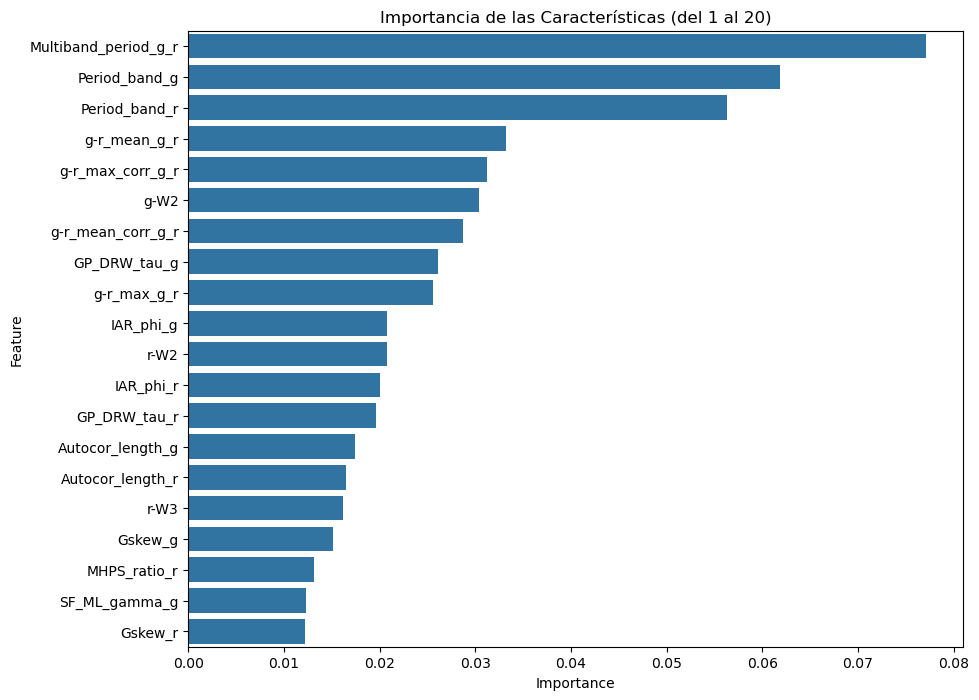

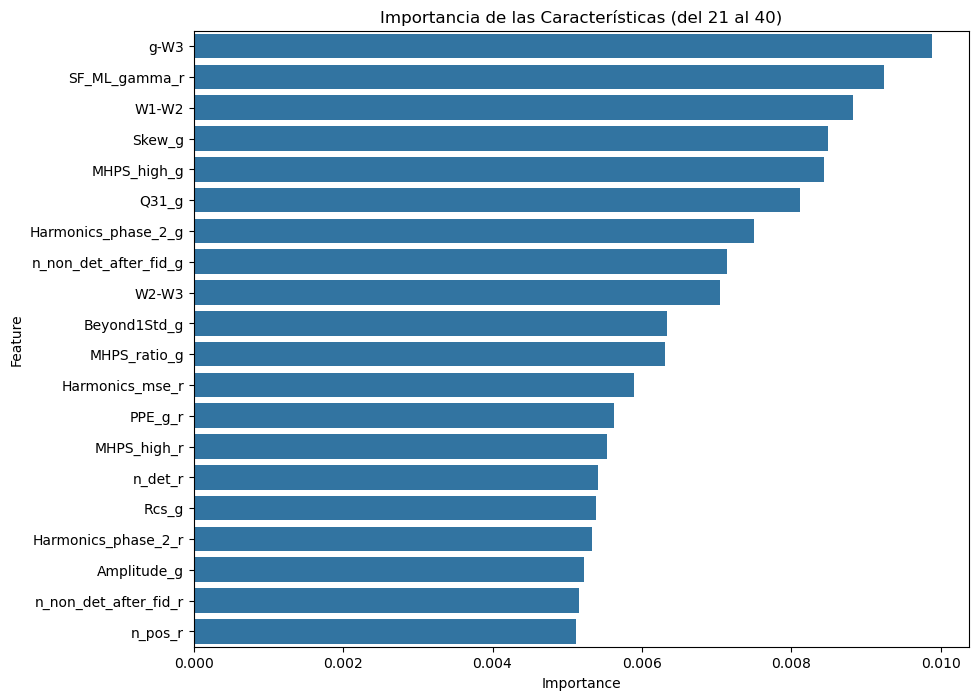

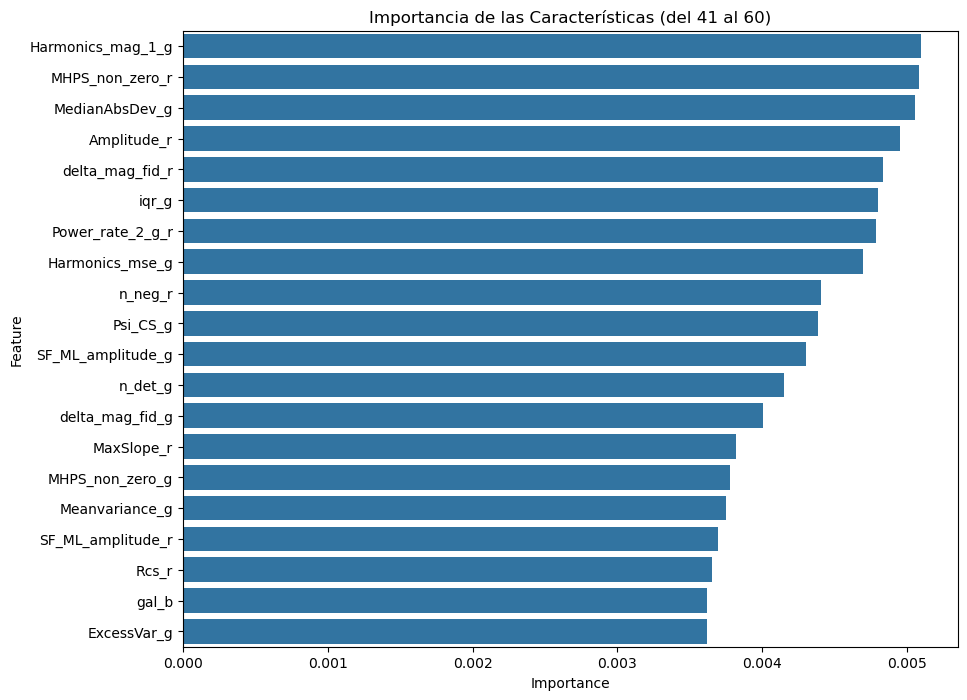

In [4]:
X = df_feats_for_forest.drop(columns=['alerceclass'])  
y = df_feats_for_forest['alerceclass']  

# conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Entrenamiento modelo RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, 
                            criterion="gini",
                            max_features="sqrt",
                            bootstrap=True,
                            max_samples=2/3,
                            oob_score=True,
                            random_state=42,
                            class_weight='balanced')
clf.fit(X, y)

feature_importances = clf.feature_importances_

# importancia de las características
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Dividir las características en grupos más pequeños para visualizarlas mejor
num_features = len(importance_df)
features_per_plot = 20  # Número de características por gráfico

count = 0
for i in range(0, num_features, features_per_plot):
    if count < 3:
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.iloc[i:i + features_per_plot])
        plt.title(f'Importancia de las Características (del {i + 1} al {i + features_per_plot})')
        plt.show()
        count += 1
    else:
        break    

#### Opción 1) DownSampling (datos entrenamiento)

In [17]:
df_feats_for_forest["alerceclass"].value_counts()

alerceclass
EB      2689
RRL     2652
LPV     1374
CEP     1172
DSCT     532
Name: count, dtype: int64

In [18]:
# Supongamos que df es tu DataFrame y 'alerceclass' es la columna de clases
class_counts = df_feats_for_forest['alerceclass'].value_counts()
min_class_count = class_counts.min()

# Crear un nuevo DataFrame vacío para los datos submuestreados
df_subsampled = pd.DataFrame()

for class_label in class_counts.index:
    df_class = df_feats_for_forest[df_feats_for_forest['alerceclass'] == class_label]
    # Submuestreo
    df_class_subsampled = df_class.sample(min_class_count, random_state=42)
    df_subsampled = pd.concat([df_subsampled, df_class_subsampled], axis=0)

# Mezclar los datos para evitar cualquier orden residual
df_subsampled = shuffle(df_subsampled, random_state=42)

In [19]:
arr_class_subsampled = df_subsampled[df_subsampled.columns[0]].values
df_subsampled

,alerceclass,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
5464,CEP,0.819883,0.220092,0.395767,-1.662413,0.425018,0.840865,1.0,0.000472,0.100000,...,21.114700,20.224400,1.189735,1267.301146,18.639870,19.013407,18.564276,45.0,0.054994,164.210226
4612,EB,0.386026,0.139727,-0.591191,-1.299228,0.182539,0.931486,1.0,0.000128,-0.033333,...,21.083700,19.961149,0.541638,1356.268275,16.059587,15.947081,15.635972,262.0,0.024276,0.002636
3065,LPV,2.180192,0.173722,0.459108,-1.246596,1.223242,0.838261,1.0,0.007141,0.433333,...,21.059799,20.187799,4.332781,1420.056412,13.361829,14.451886,12.623312,230.0,0.215802,0.067078
3832,CEP,0.314264,0.143078,-0.113989,-1.605629,0.162339,0.863687,1.0,0.000132,-0.033333,...,20.870800,19.942200,0.522623,1361.127674,14.239833,14.116208,13.882206,90.0,0.020488,0.015879
3812,LPV,0.303541,0.274266,1.682838,2.208516,0.385309,0.685476,1.0,0.000859,-0.233333,...,24.881599,19.918400,1.753538,1416.100972,13.828663,13.137140,12.583224,735.0,0.105384,0.030485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7816,CEP,0.954120,0.147045,0.854780,-0.290349,0.598270,0.866450,1.0,0.001411,0.100000,...,20.685499,19.625700,2.271265,1087.063391,16.311075,15.896832,15.255987,56.0,0.125603,0.022940
2870,LPV,0.651675,0.293724,0.641019,-1.248638,0.309118,0.848521,1.0,0.000422,0.166667,...,21.083000,20.499201,0.910099,1444.029259,15.392049,15.034077,14.660830,290.0,0.043461,0.217050
3040,LPV,2.114552,0.205146,-0.305255,-0.673795,1.642414,0.825821,1.0,0.011731,0.033333,...,21.271200,20.205450,7.011106,1424.044028,15.705126,15.157859,11.556517,274.0,0.239722,0.122389
6077,LPV,0.472522,0.400284,0.369350,-1.204260,0.268129,0.929184,1.0,0.000274,-0.033333,...,21.037600,20.221701,0.960194,1358.134526,15.952293,16.133135,15.723373,125.0,0.042002,0.101384


#### Opción 2) UpSampling (datos entrenamiento)

In [5]:
df_feats_for_forest['alerceclass'].value_counts()

alerceclass
EB      2689
RRL     2652
LPV     1374
CEP     1172
DSCT     532
Name: count, dtype: int64

In [6]:
class_counts = df_feats_for_forest['alerceclass'].value_counts()
max_count = class_counts.max()

df_feats_for_forest_sam = pd.DataFrame()

for class_label in class_counts.index:
    df_class = df_feats_for_forest[df_feats_for_forest['alerceclass'] == class_label]
    resampled_df_class = df_class.sample(max_count, replace=True, random_state=42)  # Realiza el upsampling
    df_feats_for_forest_sam = pd.concat([df_feats_for_forest_sam, resampled_df_class], axis=0)

# Barajar los datos para evitar cualquier patrón antes de entrenar
df_feats_for_forest_sam = df_feats_for_forest_sam.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_feats_for_forest_sam['alerceclass'].value_counts())

arr_class_subsampled = df_feats_for_forest_sam[df_feats_for_forest_sam.columns[0]].values

alerceclass
CEP     2689
DSCT    2689
LPV     2689
EB      2689
RRL     2689
Name: count, dtype: int64


In [7]:
df_feats_for_forest_sam

,alerceclass,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
0,CEP,0.384839,0.087348,-0.422411,-1.457556,0.206882,0.942669,1.0,0.000174,0.033333,...,21.198400,20.317699,0.671251,1402.102558,15.805210,15.636198,15.271317,244.0,0.029915,0.018940
1,DSCT,0.079890,0.316779,-1.193058,0.341253,0.173163,0.784001,1.0,0.000138,-0.133333,...,34.816299,19.774600,0.470964,994.212905,14.820288,14.686326,14.349323,17.0,0.027746,2606.015759
2,LPV,0.386543,0.423254,-0.349101,-1.564339,0.202654,0.798720,1.0,0.000206,0.300000,...,21.077101,20.162001,0.669875,1446.019907,14.185231,14.091628,13.718199,252.0,0.033224,0.028914
3,LPV,1.940060,0.286411,-0.453662,-0.832001,1.246988,0.639877,1.0,0.007173,0.233333,...,21.200600,20.106001,4.645333,1438.087303,16.349485,14.676527,11.887198,534.0,0.199792,0.096353
4,EB,0.566864,0.098362,0.511547,-1.155003,0.324024,0.840183,1.0,0.000596,-0.033333,...,21.036600,20.136250,0.998832,1167.829317,13.713195,13.257923,12.896125,39.0,0.068256,0.202403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13440,RRL,0.572414,0.156607,-0.886962,-0.869868,0.331911,0.918146,1.0,0.000346,0.100000,...,20.979601,20.070601,1.080355,1466.935370,17.942369,17.701909,17.018435,574.0,0.048345,0.056481
13441,DSCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.118401,20.226801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13442,LPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.198400,20.341450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13443,EB,0.493978,0.166326,0.046002,-1.716275,0.244311,0.912758,1.0,0.000272,0.100000,...,21.041401,20.080199,0.746055,1359.082431,14.541547,14.778370,14.445278,496.0,0.025939,0.007009


#### Normalización

In [8]:

importance_df_ = importance_df[importance_df.columns[:-1]].head(90)
importance_arr = importance_df_["Feature"].values

df_feats_for_autoen = df_feats_for_forest_sam[importance_arr]
df_feats_for_autoen

,Multiband_period_g_r,Period_band_g,Period_band_r,g-r_mean_g_r,g-r_max_corr_g_r,g-W2,g-r_mean_corr_g_r,GP_DRW_tau_g,g-r_max_g_r,IAR_phi_g,...,Harmonics_phase_3_g,PercentAmplitude_g,Harmonics_mag_5_r,ExcessVar_r,SPM_chi_g,SmallKurtosis_g,Beyond1Std_r,SPM_chi_r,rb,Power_rate_1/2_g_r
0,0.595369,0.595369,0.595369,0.196394,0.386225,2.325885,0.581688,0.306396,0.092970,4.208947e-02,...,4.147487,0.041453,0.018940,0.000174,86.200571,-0.825329,0.422131,98.879366,0.818571,0.057958
1,0.131250,0.131250,0.131250,0.353990,0.316222,NaN,0.480149,0.068272,-0.237152,4.753081e-13,...,4.311353,0.041335,2606.015759,0.000138,234.968346,-0.713722,0.235294,192.774036,0.780714,0.018378
2,0.997951,0.997951,0.499500,1.807448,1.879362,9.406768,2.047141,196.185887,1.474511,9.956854e-01,...,0.649412,0.041513,0.028914,0.000206,80.648103,-1.448193,0.436508,431.766682,0.766667,0.527359
3,246.753248,246.753248,246.753248,1.713871,1.345716,9.793159,1.740632,716.416690,1.314535,9.987068e-01,...,3.700069,0.214650,0.096353,0.007173,29215.004927,-1.506053,0.423221,145374.796220,0.784286,0.016477
4,0.711770,0.711770,0.711770,0.342292,0.098091,1.317976,-0.022948,0.276249,0.104615,2.991921e-02,...,0.501424,0.078700,0.202403,0.000596,889.600757,2.824781,0.384615,1602.674922,0.654286,0.131605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13440,0.501889,0.501889,0.501889,-0.398334,-0.262184,0.858356,0.178446,0.810944,-0.610697,2.060871e-01,...,4.632779,0.070682,0.056481,0.000346,66.922035,-0.741090,0.393728,24.188351,0.854286,0.222852
13441,0.119456,0.119456,NaN,NaN,NaN,1.761375,NaN,2.203885,NaN,6.317524e-01,...,3.320266,0.024435,NaN,NaN,832.349747,-1.650268,NaN,NaN,0.632857,0.019579
13442,1.033845,1.033845,NaN,NaN,NaN,7.397063,NaN,0.014402,NaN,4.230063e-13,...,5.311938,0.021797,NaN,NaN,2537.097262,2.660609,NaN,NaN,0.610714,0.029398
13443,0.197631,0.197631,0.197631,0.701314,0.679770,2.538471,0.601101,0.135534,0.663917,3.882264e-04,...,6.059648,0.044198,0.007009,0.000272,138.752427,-1.029685,0.377016,294.437018,0.768571,0.004122


In [34]:
from sklearn.impute import SimpleImputer

# Seleccionamos las columnas
numerical_cols = df_feats_for_autoen.columns
imputer = SimpleImputer(strategy='most_frequent')   
 
imputed_numerical_data = imputer.fit_transform(df_feats_for_autoen[numerical_cols])
imputed_numerical_df = pd.DataFrame(imputed_numerical_data, columns=numerical_cols)

imputed_numerical_df

,Period_band_g,Multiband_period_g_r,Period_band_r,g-r_mean_g_r,g-r_max_corr_g_r,g-W2,g-r_max_g_r,g-r_mean_corr_g_r,GP_DRW_tau_g,Autocor_length_r,...,Meanvariance_g,first_mag_r,mean_mag_g,min_mag_g,delta_mjd_fid_r,SPM_A_r,Power_rate_1/4_g_r,mean_mag_r,gal_l,Mean_r
0,0.595369,0.595369,0.595369,0.196394,0.386225,2.325885,0.092970,0.581688,0.306396,1.0,...,0.016386,15.805210,16.217885,15.657541,1402.102558,1.561060,0.002929,15.636198,79.847865,15.636198
1,0.131250,0.131250,0.131250,0.353990,0.316222,0.973805,-0.237152,0.480149,0.068272,1.0,...,0.015682,14.820288,15.166476,14.665545,994.212905,3.397236,0.000838,14.686326,26.284671,14.686326
2,0.997951,0.997951,0.499500,1.807448,1.879362,9.406768,1.474511,2.047141,196.185887,42.0,...,0.017199,14.185231,16.138768,15.597561,1446.019907,6.389297,0.080057,14.091628,70.287256,14.091628
3,246.753248,246.753248,246.753248,1.713871,1.345716,9.793159,1.314535,1.740632,716.416690,20.0,...,0.134192,16.349485,16.417159,13.232915,1438.087303,120.893629,0.001214,14.676527,116.567542,14.676527
4,0.711770,0.711770,0.711770,0.342292,0.098091,1.317976,0.104615,-0.022948,0.276249,1.0,...,0.023978,13.713195,13.234976,12.994216,1167.829317,28.366102,0.018772,13.257923,138.734825,13.257923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13440,0.501889,0.501889,0.501889,-0.398334,-0.262184,0.858356,-0.610697,0.178446,0.810944,8.0,...,0.025050,17.942369,17.880355,16.756250,1466.935370,0.216094,0.036790,17.701909,96.716921,17.701909
13441,0.119456,0.119456,999.999953,-0.260430,-0.185009,1.761375,-0.310000,-0.031787,2.203885,1.0,...,0.009739,14.797421,12.504375,12.344978,0.000000,0.368322,0.024169,13.895941,58.222283,14.482045
13442,1.033845,1.033845,999.999953,-0.260430,-0.185009,7.397063,-0.310000,-0.031787,0.014402,1.0,...,0.007095,14.797421,12.403063,12.261984,0.000000,0.368322,0.180518,13.895941,80.479875,14.482045
13443,0.197631,0.197631,0.197631,0.701314,0.679770,2.538471,0.663917,0.601101,0.135534,2.0,...,0.015719,14.541547,15.379471,15.125048,1359.082431,4.187476,0.000464,14.778370,127.526999,14.778370


In [35]:
# Normalización datos
cols = imputed_numerical_df.columns
scaler = StandardScaler()

scaled_numerical_data = scaler.fit_transform(imputed_numerical_df)
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=cols)
scaled_numerical_df.insert(0, "alerceclass", arr_class_subsampled)

scaled_numerical_df

,alerceclass,Period_band_g,Multiband_period_g_r,Period_band_r,g-r_mean_g_r,g-r_max_corr_g_r,g-W2,g-r_max_g_r,g-r_mean_corr_g_r,GP_DRW_tau_g,...,Meanvariance_g,first_mag_r,mean_mag_g,min_mag_g,delta_mjd_fid_r,SPM_A_r,Power_rate_1/4_g_r,mean_mag_r,gal_l,Mean_r
0,CEP,-0.375201,-0.326095,-0.440782,-0.411294,-0.287998,-0.350728,-0.395601,-0.215021,-0.010223,...,-0.147821,0.345226,0.235490,0.221182,0.663945,-0.226645,-0.446689,0.279206,-0.382744,0.261929
1,DSCT,-0.376873,-0.330686,-0.442224,-0.239294,-0.360049,-0.711577,-0.718541,-0.321585,-0.010223,...,-0.183314,-0.240797,-0.321934,-0.303863,-0.246670,-0.188997,-0.480823,-0.282524,-1.114682,-0.319175
2,LPV,-0.373750,-0.322113,-0.441080,1.347005,1.248833,1.539050,0.955884,1.322964,-0.010223,...,-0.106882,-0.618652,0.193545,0.189436,0.761991,-0.127650,0.812019,-0.634215,-0.513390,-0.682995
3,LPV,0.512025,2.108931,0.324178,1.244875,0.699571,1.642172,0.799388,1.001285,-0.010222,...,5.786371,0.669066,0.341139,-1.062127,0.744281,2.220081,-0.474687,-0.288320,0.119028,-0.325170
4,EB,-0.374781,-0.324944,-0.440420,-0.252062,-0.584564,-0.619723,-0.384209,-0.849582,-0.010223,...,0.234580,-0.899511,-1.345956,-1.188466,0.140929,0.322950,-0.188135,-1.127246,0.421943,-1.193032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13440,RRL,-0.375538,-0.327020,-0.441072,-1.060379,-0.955382,-0.742389,-1.083959,-0.638220,-0.010223,...,0.288595,1.616823,1.116880,0.802709,0.808685,-0.254222,0.105911,1.500816,-0.152230,1.525672
13441,DSCT,-0.376916,-0.330803,2.664966,-0.909871,-0.875948,-0.501387,-0.789804,-0.858859,-0.010223,...,-0.482685,-0.254403,-1.733298,-1.532096,-2.466255,-0.251100,-0.100057,-0.749939,-0.678257,-0.444149
13442,LPV,-0.373620,-0.321758,2.664966,-0.909871,-0.875948,1.002691,-0.789804,-0.858859,-0.010223,...,-0.615830,-0.254403,-1.787010,-1.576023,-2.466255,-0.251100,2.451524,-0.749939,-0.374108,-0.444149
13443,EB,-0.376634,-0.330030,-0.442018,0.139774,0.014136,-0.293992,0.162924,-0.194647,-0.010223,...,-0.181444,-0.406647,-0.209011,-0.060657,0.567903,-0.172795,-0.486914,-0.228092,0.268788,-0.262866


#### Plot 5 primeras (más relevantes) features

Text(0.5, 1.02, 'Descripción preliminar de las primeras 5 "Features"')

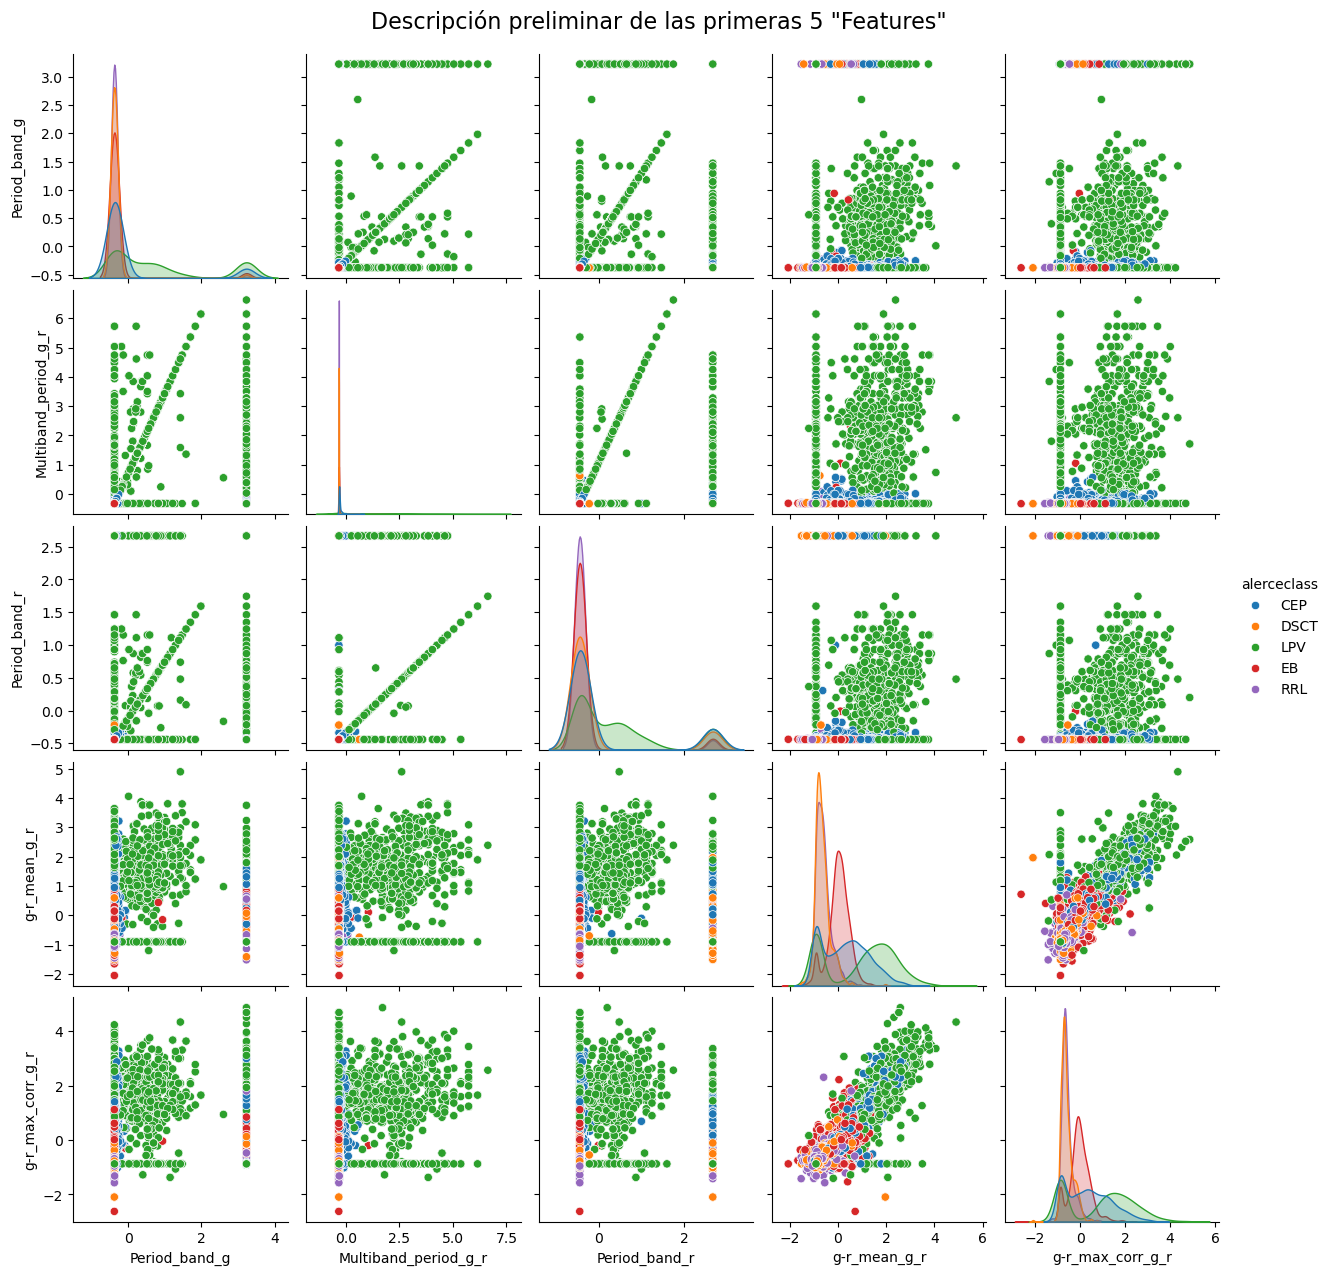

In [20]:
# Muestra de las 5 primera features de cada objeto
features_df = pd.DataFrame(scaled_numerical_df[["alerceclass", "Period_band_g", "Multiband_period_g_r", "Period_band_r", "g-r_mean_g_r", "g-r_max_corr_g_r"]])
features_df = features_df.dropna()

# Se observan las primeros 5 features de cada objeto en relación con la clase a la que pertenecen
sns.pairplot(data=features_df, hue='alerceclass', ).fig.suptitle('Descripción preliminar de las primeras 5 "Features"', y=1.02, fontsize=16)

#### Entrenamiento Autoencoder

In [36]:
scaled_numerical_df['alerceclass'].value_counts()

alerceclass
CEP     2689
DSCT    2689
LPV     2689
EB      2689
RRL     2689
Name: count, dtype: int64

In [37]:

X = scaled_numerical_df.drop(columns=['alerceclass']) 
y = scaled_numerical_df['alerceclass'] 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_autoen, X_test_autoen, y_train_autoen, y_test_autoen = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [49]:
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD, Nadam, Adam, RMSprop, Adagrad, Adamax, Ftrl
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1974 - val_loss: 0.1251
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1194 - val_loss: 0.1078
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1030 - val_loss: 0.0950
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0916 - val_loss: 0.0854
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0822 - val_loss: 0.0773
Epoch 6/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0742 - val_loss: 0.0696
Epoch 7/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0677 - val_loss: 0.0645
Epoch 8/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 - val_loss: 0.0593
Epoch 9/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0570 - val_loss: 0.0554
Epoch 10/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - val_loss: 0.0516
Epoch 11/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - val_loss: 0.0491
Epoch 12/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

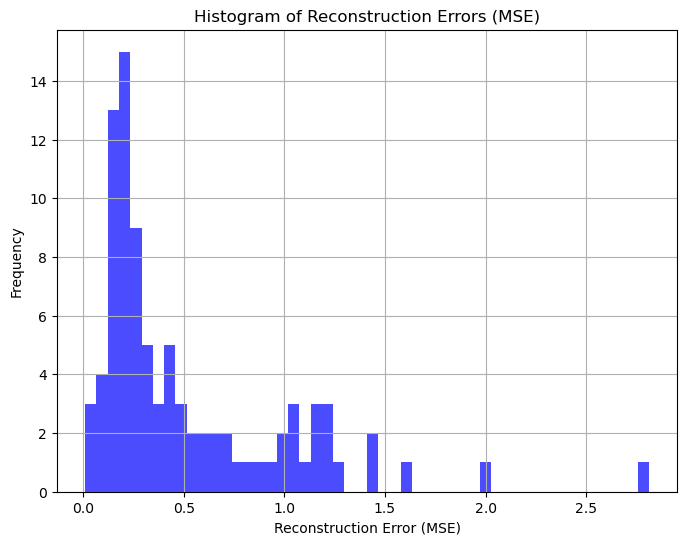

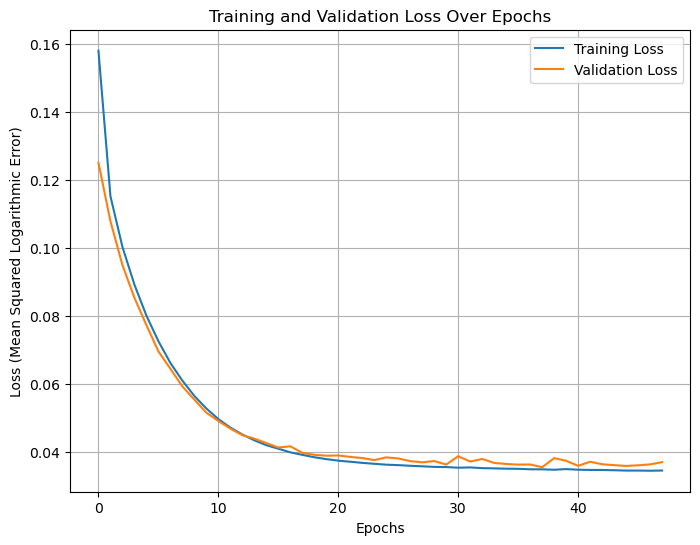

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [56]:
dim_entrada = X_train_autoen.shape[1]

capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(dim_entrada, activation="selu", kernel_regularizer=l2(0.0001))(capa_entrada)   
encoder = Dense(dim_entrada, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
encoder = Dense(80, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
encoder = Dense(60, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
encoder = Dense(50, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
encoder = Dense(40, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
encoder = Dense(35, activation="selu", kernel_regularizer=l2(0.0001))(encoder)

# dropout = Dropout(0.25)(encoder)

decoder = Dense(40, activation="selu", kernel_regularizer=l2(0.0001))(encoder)
decoder = Dense(50, activation="selu", kernel_regularizer=l2(0.0001))(decoder)
decoder = Dense(60, activation="selu", kernel_regularizer=l2(0.0001))(decoder)
decoder = Dense(80, activation="selu", kernel_regularizer=l2(0.0001))(decoder)
decoder = Dense(dim_entrada, activation="selu", kernel_regularizer=l2(0.0001))(decoder)
decoder = Dense(dim_entrada, activation="selu", kernel_regularizer=l2(0.0001))(decoder)
decoder = Dense(dim_entrada, activation="selu", kernel_regularizer=l2(0.0001))(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)
encoder_model = Model(inputs=capa_entrada, outputs=encoder)

autoencoder.compile(
    loss='mean_squared_logarithmic_error',
    optimizer=Nadam(learning_rate=0.001, epsilon=1e-08, beta_1=0.9, beta_2=0.999)
)

# SGD(learning_rate=0.01)

history = autoencoder.fit(
    X_train_autoen, 
    X_train_autoen,
    epochs=150,
    batch_size=100, 
    validation_data=[X_test_autoen, X_test_autoen],
    callbacks=[EarlyStopping(patience=10)]
)

# Obtener las reconstrucciones del autoencoder en el conjunto de test
reconstructed_X_test = autoencoder.predict(X_test_autoen)

# Calcular el MSE por cada muestra y el promedio general
mse_per_sample = mean_squared_error(X_test_autoen, reconstructed_X_test, multioutput='raw_values')
mse_mean = mse_per_sample.mean()
print(f'MSE Promedio: {mse_mean}')

# Calcular el MAE por cada muestra y el promedio general
mae_per_sample = mean_absolute_error(X_test_autoen, reconstructed_X_test, multioutput='raw_values')
mae_mean = mae_per_sample.mean()
print(f'MAE Promedio: {mae_mean}')


# Graficar el histograma del error de reconstrucción (MSE)
plt.figure(figsize=(8, 6))
plt.hist(mse_per_sample, bins=50, alpha=0.7, color='b', label='MSE')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors (MSE)')
plt.grid(True)
plt.show()

# Visualización de la pérdida durante el entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Logarithmic Error)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

embedding_feats = encoder_model.predict(X_test_autoen)

#### UMAP 2D

In [58]:
# Configurar y entrenar UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings = reducer.fit_transform(embedding_feats)

c:\Users\nicos\.conda\envs\env_inteligencia\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [62]:
embedding_df = pd.DataFrame({
    'alerceclass': y_test_autoen,   # clase
    'umap_x': umap_embeddings[:, 0],    # UMAP_1
    'umap_y': umap_embeddings[:, 1],    # UMAP_2           
})

embedding_df

,alerceclass,umap_x,umap_y
7839,DSCT,12.009951,10.156630
9524,DSCT,12.676060,16.654776
6213,DSCT,12.677747,16.649605
12113,CEP,8.415124,10.314495
868,RRL,14.738687,13.769120
...,...,...,...
12019,LPV,6.835820,-4.027236
13265,RRL,12.630167,12.898438
2336,EB,15.331324,10.285808
215,CEP,11.625026,12.346157


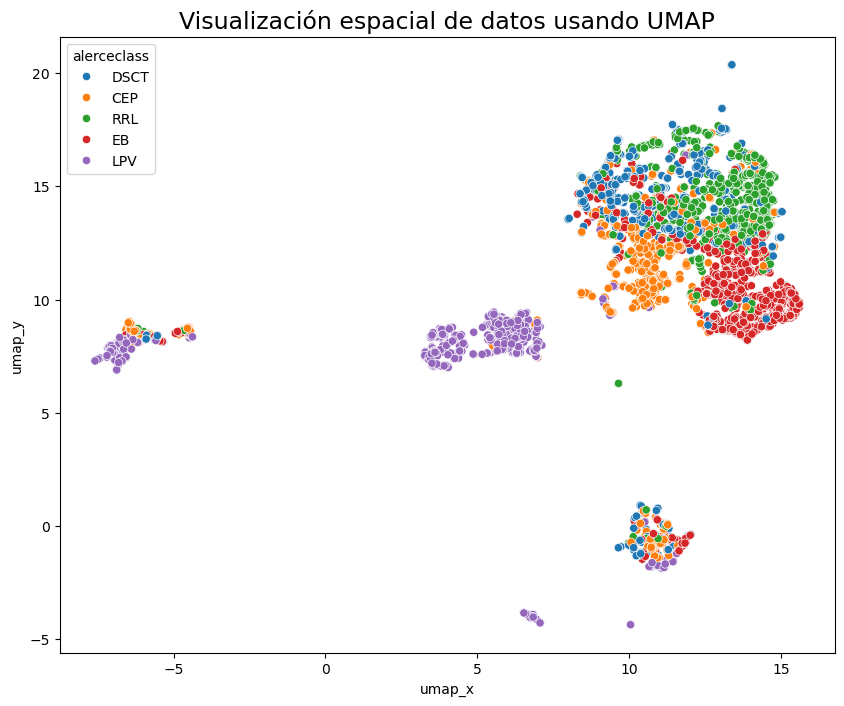

In [63]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='umap_x', y='umap_y', hue='alerceclass', data=embedding_df, palette='tab10') 
plt.title('Visualización espacial de datos usando UMAP', fontsize='17')
plt.show()

#### UMAP 3D

In [83]:
from mpl_toolkits.mplot3d import Axes3D

# Configurar y entrenar UMAP para reducir a 3 dimensiones
reducer_3d = umap.UMAP(n_neighbors=13, min_dist=0.5, n_components=3, metric='euclidean', random_state=42)
umap_embeddings_3d = reducer_3d.fit_transform(embedding_feats)

c:\Users\nicos\.conda\envs\env_inteligencia\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [84]:
embedding_df = pd.DataFrame({
    'alerceclass': y_test_autoen,   # clase
    'umap_x': umap_embeddings_3d[:, 0],    # UMAP_1
    'umap_y': umap_embeddings_3d[:, 1],    # UMAP_2
    'umap_z': umap_embeddings_3d[:, 2]     # Umap_3           
})

embedding_df

,alerceclass,umap_x,umap_y,umap_z
7839,DSCT,11.520098,11.529847,8.778026
9524,DSCT,12.991632,16.104637,8.090792
6213,DSCT,13.069983,15.996857,7.999930
12113,CEP,11.999288,11.285351,2.355523
868,RRL,11.234912,15.447505,7.755301
...,...,...,...,...
12019,LPV,9.617620,-0.994628,4.337397
13265,RRL,11.893957,14.165684,5.226304
2336,EB,9.155295,10.346119,7.175551
215,CEP,12.130276,12.883833,5.195471


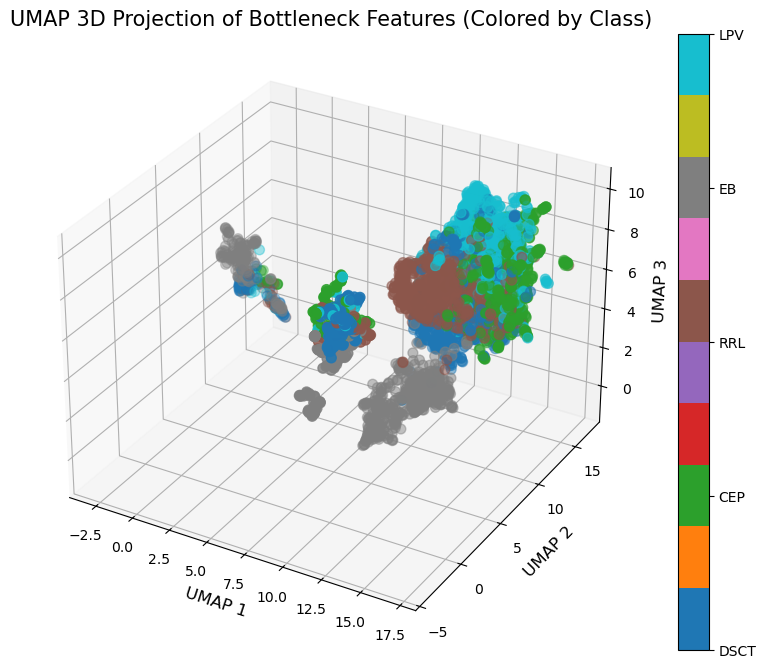

In [85]:
# Visualización en 3D con clases categóricas
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Utilizamos Seaborn para un manejo mejor de colores en función de las categorías
scatter = ax.scatter(embedding_df['umap_x'], embedding_df['umap_y'], embedding_df['umap_z'], 
                     c=embedding_df['alerceclass'].astype('category').cat.codes,  # Colorear por clase categórica
                     cmap='tab10', s=50)  # 'tab10' es un mapa de colores con 10 colores distintos

# Añadir etiquetas y título
ax.set_title('UMAP 3D Projection of Bottleneck Features (Colored by Class)', fontsize=15)
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_zlabel('UMAP 3', fontsize=12)

# Añadir barra de colores para representar las clases
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_ticklabels(embedding_df['alerceclass'].unique())  # Etiquetar el colorbar con las clases originales

plt.show()